In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier


import xgboost as xgb

In [2]:
def one_hot_encode(df, column, prefix):# found this function which is b
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def preprocess_data(df, scale=False, one_hot=False , age_groupe = False ):
    
    #drop ID - has only unique values
    df = df.drop('CLIENTNUM', axis=1)
    
    # if True create  Age_groupe
    if age_groupe == True:
        list_AgeGroup = [df]
        for column in list_AgeGroup:
            df.loc[column["Customer_Age"] < 18,  'age_group'] = 18
            df.loc[(column["Customer_Age"] >= 19) & (column["Customer_Age"] <= 29), 'age_group'] = 20
            df.loc[(column["Customer_Age"] >= 30) & (column["Customer_Age"] <= 39), 'age_group'] = 30
            df.loc[(column["Customer_Age"] >= 40) & (column["Customer_Age"] <= 49), 'age_group'] = 40
            df.loc[(column["Customer_Age"] >= 50) & (column["Customer_Age"] <= 59), 'age_group'] = 50
            df.loc[column["Customer_Age"] >= 60, 'age_group'] = 60
        
    
    # handle unknown values
    df['Income_Category'] = df['Income_Category'].replace('Unknown', np.NaN)
   
    
    # Fill ordinal missing values with modes ( Income_Category column)
    df['Income_Category'] = df['Income_Category'].fillna('Less than $40K')
    
    # handle unknown values of marital status
    df['Marital_Status'] = df['Marital_Status'].replace('Unknown', np.NaN)
    
    # Fill missing values with dominant value ( Marital_Status column)
    df['Marital_Status'] = df['Marital_Status'].fillna(df['Marital_Status'].value_counts().index[0])

    #Ordinal Variables Encoding

    Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4
    
    }
    Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
    }


    Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1
    }

    # Too many Unknown value to exclude it
    Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
    }
    
    Gender_Map = {
        'M' : 0,
        'F' : 1
    }


    
    #encoding using the function above creating + deleting old columns
    if one_hot == True:
        
        df = one_hot_encode(df, 'Marital_Status', prefix='MS')
        df = one_hot_encode(df, 'Card_Category', prefix='CC')
        df = one_hot_encode(df, 'Gender', prefix='Gender')
        df = one_hot_encode(df, 'Education_Level', prefix='Education_Level')
        df = one_hot_encode(df, 'Income_Category', prefix='Income_Category')
        if age_groupe == True :
            df = one_hot_encode(df, 'age_group', prefix='Age_Group')
    else:
        df.loc[:, 'Card_Category'] = df['Card_Category'].map(Card_Category_map)
        df.loc[:, 'Income_Category'] = df['Income_Category'].map(Income_Category_map)
        df.loc[:, 'Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
        df.loc[:, 'Education_Level'] = df['Education_Level'].map(Education_Level_map)
        df.loc[:, 'Gender'] = df['Gender'].map(Gender_Map)
    # Label Encoder
    le = LabelEncoder()
    
    # the remaining categorical data are 'objects' as datatyes
    categ = [x for x in df.columns if df[x].dtype == 'object']
    
    #fit_transform on each categorical column
    for a in categ:
        df.loc[:, a]=le.fit_transform(df.loc[:,a])
        
   
    #X["Total_Trans_Ct_Categorical"] = pd.cut(X.Total_Trans_Ct,bins = 16, labels = range(1,17)) 
    #X["Total_Trans_Amt_Categorical"] =pd.cut(X.Total_Trans_Amt,bins = 16, labels = range(1,17))

    
    
    
    y = df.Attrition_Flag 
    X = df.drop('Attrition_Flag', axis=1)
    
   
    
    
    #Scale X
    if scale == True:
        scaler = StandardScaler()
        ro_sc = RobustScaler()

        X_ =X.loc[:,['Customer_Age', 
                     'Dependent_count',
                     'Months_on_book', 
                     'Total_Relationship_Count',
                     'Months_Inactive_12_mon',
                     'Contacts_Count_12_mon',
                     'Credit_Limit',
                     'Total_Revolving_Bal',
                     'Avg_Open_To_Buy',
                     'Total_Amt_Chng_Q4_Q1',
                     'Total_Trans_Amt',
                     'Total_Trans_Ct', 
                     'Total_Ct_Chng_Q4_Q1',
                     'Avg_Utilization_Ratio']]
        
        X = X.drop(['Customer_Age',
                    'Dependent_count',
                    'Months_on_book',
                    'Total_Relationship_Count',
                    'Months_Inactive_12_mon',
                    'Contacts_Count_12_mon',
                    'Credit_Limit',
                    'Total_Revolving_Bal',
                    'Avg_Open_To_Buy', 
                    'Total_Amt_Chng_Q4_Q1',
                    'Total_Trans_Amt',
                    'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio'], axis= 1)
    
        X_ = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)
        
        X = X.merge(X_, left_index = True, right_index = True)
        
        
        X_2 = X.loc[:,['Credit_Limit', 'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt' ]]
        X = X.drop(['Credit_Limit',  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt'], axis = 1)
        
        X_2 = pd.DataFrame(ro_sc.fit_transform(X_2), columns= X_2.columns)
        X = X.merge(X_2, left_index = True, right_index = True)
       
    
        #create bins for bimodal continious data
        X["Total_Trans_Ct_Categorical"] = pd.cut(X.Total_Trans_Ct,bins = 16, labels = range(1,17)) 
        X["Total_Trans_Amt_Categorical"] =pd.cut(X.Total_Trans_Amt,bins = 16, labels = range(1,17))

    
    return X, y


    

In [3]:
data = pd.read_csv('ChurnPrediction/churn-prediction.csv')

In [4]:
X, y = preprocess_data(data, scale=False, one_hot=False) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
grid_search_clf = pickle.load(open('grid_search.sav', 'rb'))

In [18]:
grid_search_clf

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 2, 3, 4, 5, 7],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_split': [0.2, 0.4, 0.6, 0.8, 1.0, 2],
                         'n_estimators': [150, 200, 250, 300],
                         'random_state': [0]},
             scoring='accuracy', verbose=2)

In [19]:
GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=300,
                           random_state=0)

GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=300,
                           random_state=0)

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
X, y = preprocess_data(data, scale=False, one_hot=True)


skf = StratifiedKFold(n_splits=10 , shuffle = True, random_state = 42)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [ 5, 8 ]
        }

xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300, objective='binary:logistic',
                    silent=True, nthread=1)

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3 )
grid.fit(X, y)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
results = pd.DataFrame(grid.cv_results_)
results.to_csv('xgb-grid-search-results-01.csv', index=False)


pickle.dump(clf, open('grid_xgb_search.sav', 'wb'))

grid_search_clf = pickle.load(open('grid_xgb_search.sav', 'rb'))


Fitting 10 folds for each of 270 candidates, totalling 2700 fits


/Users/horiaiulian/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 All results:
{'mean_fit_time': array([ 6.75071716,  6.89102261,  6.552509  ,  6.55035231, 11.1088515 ,
        7.84244318,  8.50111136,  7.10648909,  8.72478814, 11.60086875,
       12.57007856, 11.99990315,  8.14790859,  8.82263095,  9.33240721,
        7.25127347,  8.40895522,  8.83844745,  6.66725931,  6.80279479,
        6.51413379,  6.56214311,  6.251

NameError: name 'clf' is not defined

In [27]:
#pickle.dump(xgb, open('grid_xgb_search.sav', 'wb'))

grid_search_clf = pickle.load(open('grid_xgb_search.sav', 'rb'))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
grid_search_clf.fit(X_train, y_train)

[16:33:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:33:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
gridPredict= grid_search_clf.predict(X_test)

In [21]:
data = pd.read_csv('xgb-grid-search-results-01.csv')

In [ ]:
data.info()

<Figure size 2016x2016 with 0 Axes>

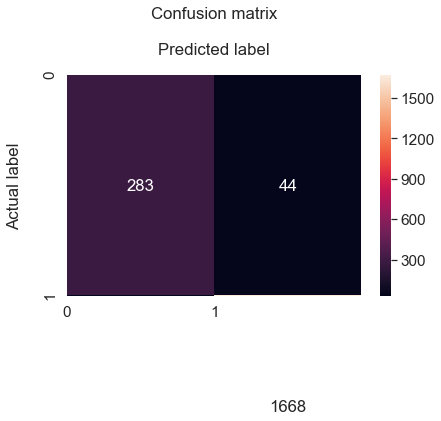

In [33]:
cm = confusion_matrix(y_test, gridPredict) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,28))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
plt.show()

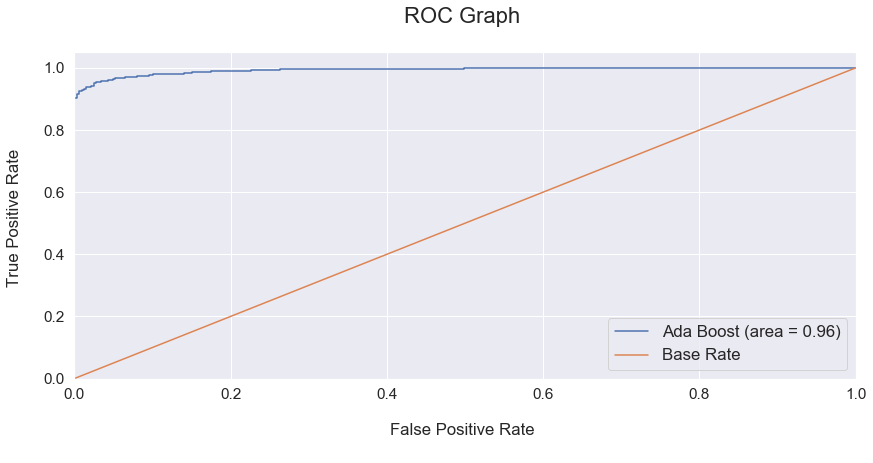

In [37]:
#get the ROC graph

probs = grid_search_clf.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, gridPredict )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, grid_search_clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Ada Boost ROC
plt.plot(rf_fpr, rf_tpr, label='Ada Boost (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

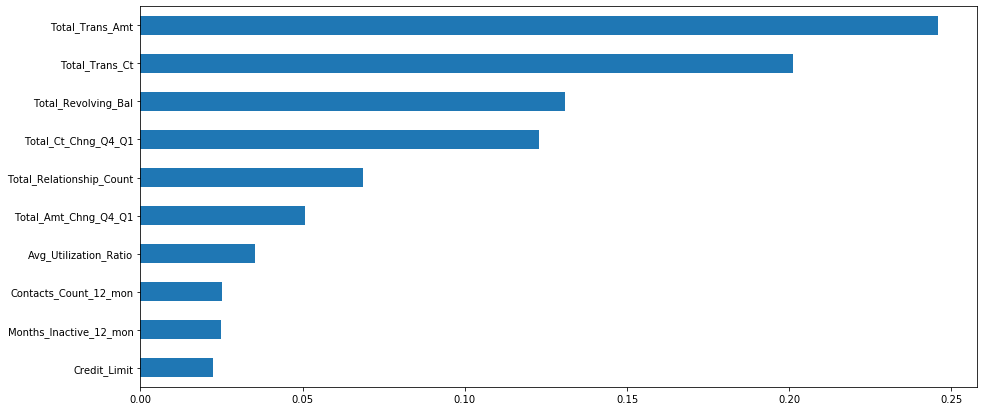

In [35]:
# get important features
plt.figure(figsize=(15,7))
feature_list = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_list.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [14]:
from xgboost import XGBClassifier
n_estimators = 500
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)
xgb.fit(X_train, y_train)




/Users/horiaiulian/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)